# Testing how well we can predict extreme bandgaps using inverse design

In [170]:
from gpt3forchem.data import get_bandgap_data
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns


from sklearn.model_selection import train_test_split

from gpt3forchem.api_wrappers import query_gpt3, extract_prediction, extract_inverse_prediction, fine_tune
from gpt3forchem.output import test_inverse_bandgap

import time

from rdkit.Contrib.SA_Score.sascorer import calculateScore as calculate_sascore

from fastcore.helpers import save_pickle

import numpy as np
from rdkit import Chem 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

In [139]:
def get_xtb_results(filename, results):
    outputs = []
    for res in results:
        temp = res["temperature"]
        with open(f'for_xtb_opt/{filename}_{temp}_gaps.txt', 'r') as f:
            gaps_ = f.readlines()
            if not gaps_: print(f"No results found for {temp}"); continue
            gaps = []
            for _gap in gaps_:
                name, gap = _gap.split()
                gaps.append((int(name.split("/")[-1]), float(gap) if gap !='None' else np.nan))

        predicted, true = [], []

        for i, g in gaps:
            predicted.append(g)
            true.append(res["expected"][i])

        true, predicted = np.array(true), np.array(predicted)

        not_nan_mask = ~np.isnan(predicted)
        outputs.append(
            {
                'predicted': predicted,
                'true': true,
                'temperature': temp,
                 'r2_score': r2_score(true[not_nan_mask], predicted[not_nan_mask]),
                'mae': mean_absolute_error(true[not_nan_mask], predicted[not_nan_mask]),
            }
        )
    return outputs

In [4]:
data = get_bandgap_data()

In [15]:
random_bandgaps = np.random.normal(4.0, 0.5, size=300)

/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


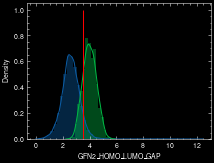

In [16]:
fig, ax = plt.subplots()
sns.distplot(data['GFN2_HOMO_LUMO_GAP'] * 27.2114, ax=ax)
sns.distplot(random_bandgaps, ax=ax)
ax.vlines(3.5, 0, 1.0, color='red')

Let's try this in two settings: (1) we try to use the little data we have to predict the biased distribution and (2) we completely ignore all training data above 3.5 eV and try to predict the unbiased distribution.

## Random split and biased test set

In [26]:
train_set_random, test_set_random = train_test_split(data, train_size=1_000, test_size=200, random_state=42)

In [27]:
PROMPT_TEMPLATE_bandgap_inverse = "What is a molecule with a bandgap of {} eV###"
COMPLETION_TEMPLATE_bandgap_inverse = "{}@@@"


def generate_inverse_photoswitch_prompts(
    data: pd.DataFrame, representation: str = "smiles"
) -> pd.DataFrame:
    prompts = []
    completions = []
    smiles = []
    for i, row in data.iterrows():

        prompt = PROMPT_TEMPLATE_bandgap_inverse.format(
            np.round(row["GFN2_HOMO_LUMO_GAP"] * 27.2114, 1)
        )

        completion = COMPLETION_TEMPLATE_bandgap_inverse.format(row[representation])
        prompts.append(prompt)
        completions.append(completion)
        smiles.append(row["smiles"])

    prompts = pd.DataFrame(
        {"prompt": prompts, "completion": completions, "SMILES": smiles}
    )

    return prompts

In [29]:
train_prompts_random = generate_inverse_photoswitch_prompts(train_set_random)

test_prompts_random = generate_inverse_photoswitch_prompts(test_set_random)

In [25]:
train_prompts_random

,prompt,completion,SMILES
0,What is a molecule with a bandgap of 2.9 eV###,[H]c1nc([C@]2([H])C(=O)N(C([H])([H])[H])C(C([H...,[H]c1nc([C@]2([H])C(=O)N(C([H])([H])[H])C(C([H...
1,What is a molecule with a bandgap of 1.6 eV###,[H]c1nc(N([H])c2c([H])c(Cl)c(C(=O)N([H])[C@]3(...,[H]c1nc(N([H])c2c([H])c(Cl)c(C(=O)N([H])[C@]3(...
2,What is a molecule with a bandgap of 2.3 eV###,[H]/C(=C(/[H])C([H])([H])n1c(-c2c([H])c([H])c(...,[H]/C(=C(/[H])C([H])([H])n1c(-c2c([H])c([H])c(...
3,What is a molecule with a bandgap of 1.7 eV###,[H]c1c([H])c(-c2c([H])c([H])c(N([H])C(=O)c3c([...,[H]c1c([H])c(-c2c([H])c([H])c(N([H])C(=O)c3c([...
4,What is a molecule with a bandgap of 1.9 eV###,[H]c1nc(-n2nc(N([H])c3c([H])c([H])c(C4([H])C([...,[H]c1nc(-n2nc(N([H])c3c([H])c([H])c(C4([H])C([...
...,...,...,...
495,What is a molecule with a bandgap of 2.4 eV###,[H]OC(=O)c1c(N([H])S(=O)(=O)c2c([H])c([H])c([H...,[H]OC(=O)c1c(N([H])S(=O)(=O)c2c([H])c([H])c([H...
496,What is a molecule with a bandgap of 3.6 eV###,[H]N1C([H])([H])C([H])([H])N(C([H])([H])C(=O)N...,[H]N1C([H])([H])C([H])([H])N(C([H])([H])C(=O)N...
497,What is a molecule with a bandgap of 0.7 eV###,[H]c1nc(N([H])c2c([H])c([H])c(F)c(Cl)c2[H])c2c...,[H]c1nc(N([H])c2c([H])c([H])c(F)c(Cl)c2[H])c2c...
498,What is a molecule with a bandgap of 1.7 eV###,[H]C([H])=C([H])C(=O)N([H])c1c([H])c([H])c([H]...,[H]C([H])=C([H])C(=O)N([H])c1c([H])c([H])c([H]...


In [34]:
train_size = len(train_set_random)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename_random = f"run_files/{filename_base}_train_prompts_bandgap_inverse_smiles_{train_size}.jsonl"

train_prompts_random.to_json(train_filename_random, orient="records", lines=True)


valid_filename_random = f"run_files/{filename_base}_valid_prompts_bandgap_inverse_smiles_{train_size}.jsonl"
test_prompts_random.to_json(valid_filename_random, orient="records", lines=True)

In [35]:
modelname_random = fine_tune(train_filename_random, valid_filename_random)   

Fine-tune ft-KBzV2aU0bJBTSK3GKV6vggJG has the status "running" and will not be logged
🎉 wandb sync completed successfully


In [37]:
def test_inverse_model(
    modelname,
    test_prompts,
    df_train,
    max_tokens: int = 250,
    temperatures=None,
    representation="SMILES",
):
    temperatures = temperatures or [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
    train_smiles = df_train["SMILES"].to_list()
    results = []
    for temperature in temperatures:
        try:
            print(f"Testing temperature {temperature} for {representation}")
            result = test_inverse_bandgap(
                test_prompts,
                modelname,
                train_smiles=train_smiles,
                temperature=temperature,
                max_tokens=max_tokens,
                representation=representation,
            )

            results.append(result)
        except Exception as e:
            print(e)
            pass

    return results

In [42]:
random_test_results = test_inverse_model(modelname_random, test_prompts_random, train_prompts_random)

Testing temperature 0 for SMILES


2022-11-30 22:36:49.814 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-30 22:36:49.819 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-30 22:36:49.861 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 200 samples
2022-11-30 22:36:50.178 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-30 22:38:15.489 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (81.16275694474034, 8.918514126808853e-08)
2022-11-30 22:38:16.252 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.291539715121755

Testing temperature 0.25 for SMILES


2022-11-30 22:39:26.259 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-30 22:39:26.262 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-11-30 22:39:26.304 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 142 samples
2022-11-30 22:39:26.527 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-30 22:40:00.127 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (41.89966872982133, 0.00022942514529373565)
2022-11-30 22:40:00.863 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.17189881425441

Testing temperature 0.5 for SMILES


2022-11-30 22:41:11.015 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c(C([H])([H])[H])c([H])c(N([H])C(=O)N([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])[H])c1[H]
2022-11-30 22:41:11.016 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c(C([H])([H])[H])c([H])c(N([H])C(=O)N([H])c2c([H])c([H])c([H])c([H])c2C([H])([H])[H])c1[H]
2022-11-30 22:41:11.067 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 122 samples
2022-11-30 22:41:11.342 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-30 22:42:06.091 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (28.65400579895571, 0.0032444768476936957)
2022-11-30 22:42:06.822 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.366

Testing temperature 0.75 for SMILES


2022-11-30 22:43:16.125 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]/N=C(/c1nc([H])c([H])c([H])c1[H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]
2022-11-30 22:43:16.125 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]/N=C(/c1nc([H])c([H])c([H])c1[H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H]
2022-11-30 22:43:16.188 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 97 samples
2022-11-30 22:43:16.410 | INFO     | gpt3forchem.outpu

Testing temperature 1.0 for SMILES


2022-11-30 22:45:38.665 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)c1c([H])c([H])c(-n2c(-c3([H])nc([H])c([H])c3[H])nc2[H])nc1[H])C([H])([H])[H]
2022-11-30 22:45:38.666 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]OC([H])([H])[C@@]([H])(C(=O)N([H])S(=O)(=O)c1c([H])c([H])c(-n2c(-c3([H])nc([H])c([H])c3[H])nc2[H])nc1[H])C([H])([H])[H]
2022-11-30 22:45:38.732 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 54 samples
2022-11-30 22:45:38.828 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-11-30 22:46:47.499 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (30.06588195373145, 0.002446305404539369)
2022-11-30 22:46:47.859 | DEBUG    | gpt3forchem.output:test_inverse_ba

Testing temperature 1.25 for SMILES


2022-11-30 22:47:58.263 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]Oc1c([H])c([H])c([H])c([C@]2([H])C([H])([H])[C@@]3([H])N(O[H])[C@=O]3C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]3([H])O[H])c1[H]
2022-11-30 22:47:58.263 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]Oc1c([H])c([H])c([H])c([C@]2([H])C([H])([H])[C@@]3([H])N(O[H])[C@=O]3C([H])([H])C(C([H])([H])[H])(C([H])([H])[H])[C@@]3([H])O[H])c1[H]
2022-11-30 22:47:58.318 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 21 samples
2022-11-30 22:47:58.461 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
[22:48:20] WARNING: not removing hydrogen atom without neighbors
2022-11-30 22:48:29.443 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (46.90723029860626

Testing temperature 1.5 for SMILES


2022-11-30 22:49:41.937 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nn2c(C(=O)N([H])C([H])([H])c3nc(N4C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])SC(=O)OC5C([H])([H])[H])C([H])([H])O4)nc(-n3c3c([H])c([H])n([P]^UP)(Vert)c3[H])c3c([H])nn32)nc(N2[H])c2c([H])n2c([H])c([H])c([H])c12
2022-11-30 22:49:41.938 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nn2c(C(=O)N([H])C([H])([H])c3nc(N4C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])SC(=O)OC5C([H])([H])[H])C([H])([H])O4)nc(-n3c3c([H])c([H])n([P]^UP)(Vert)c3[H])c3c([H])nn32)nc(N2[H])c2c([H])n2c([H])c([H])c([H])c12
2022-11-30 22:49:41.975 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 10 samples
2022-11-30 22:49:42.057 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
[22:49:50] WARNING: not removi

In [45]:
timestamp = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime())

In [46]:
save_pickle(f"run_files/{timestamp}-random_test_results_extrapolation_smiles.pkl", random_test_results)

In [47]:
smiles_500_random_sets = []

for res in random_test_results:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_500_random_sets.append(result)

for res in smiles_500_random_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}_smiles_500_random_sets_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

In [71]:
random_xtb_results = get_xtb_results('2022-11-30-23-07-49_smiles_500_random_sets', smiles_500_random_sets)
save_pickle('run_files/2022-12-01-random-xtb-results', random_xtb_results)

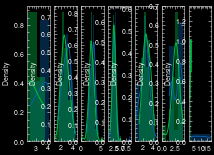

In [77]:
fig, ax = plt.subplots(1,7)
for i in range(7):
    sns.distplot(random_xtb_results[i]['predicted'], ax=ax[i], kde_kws={"cut":0}, label='predicted')
    sns.distplot(random_xtb_results[i]['true'], ax=ax[i], kde_kws={"cut":0}, label='queried')  
  

In [78]:
random_bandgaps = np.random.normal(4.0, 0.5, size=200) / 27.2114
test_set_random_biased = test_set_random.copy()
test_set_random_biased['GFN2_HOMO_LUMO_GAP'] = random_bandgaps


test_prompts_random_biased = generate_inverse_photoswitch_prompts(test_set_random_biased)
valid_filename_random_biased = f"run_files/{filename_base}_valid_prompts_bandgap_inverse_smiles_random_biased_{train_size}.jsonl"
test_prompts_random_biased.to_json(valid_filename_random_biased, orient="records", lines=True)

In [85]:
random_biased_test_results = test_inverse_model(modelname_random, test_prompts_random_biased, train_prompts_random)

Testing temperature 0 for SMILES


2022-12-01 15:46:19.033 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-01 15:46:19.036 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-01 15:46:19.076 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 200 samples
2022-12-01 15:46:19.389 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 15:46:44.191 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (76.85357248786127, 2.1114631715259432e-07)
2022-12-01 15:46:44.752 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.19101598750301

Testing temperature 0.25 for SMILES


2022-12-01 15:47:54.109 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c(C([H])([H])N([H])C(=O)C([H])([H])N2C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([
2022-12-01 15:47:54.110 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c(C([H])([H])N([H])C(=O)C([H])([H])N2C([H])([H])C([H])([H])N(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([
2022-12-01 15:47:54.170 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frec

Testing temperature 0.5 for SMILES


2022-12-01 15:49:29.036 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C(=O)N([H])c2nc(C([H])([H])[H])nc(N([H])C(=O)C([H])([H])[H])c2C([H])([H])[H])c([H])c1[H]
2022-12-01 15:49:29.038 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C(=O)N([H])c2nc(C([H])([H])[H])nc(N([H])C(=O)C([H])([H])[H])c2C([H])([H])[H])c([H])c1[H]
2022-12-01 15:49:29.089 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 133 samples
2022-12-01 15:49:29.212 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 15:49:53.425 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (27.955334071792137, 0.0037310454079815896)
2022-12-01 15:49:54.066 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div

Testing temperature 0.75 for SMILES


2022-12-01 15:51:03.223 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]Oc1c([H])c([H])c([C@]2([H])C([H])([H])[C@@]([H])(C([H])([H])[H])[C@@]3([H])N(C([H])([H])[H])[C@]([H])(C([H])([H])[H])N([H])[C@]([H])(C([H])([H])[H])C3([H])[H])c([H])c1F
2022-12-01 15:51:03.224 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]Oc1c([H])c([H])c([C@]2([H])C([H])([H])[C@@]([H])(C([H])([H])[H])[C@@]3([H])N(C([H])([H])[H])[C@]([H])(C([H])([H])[H])N([H])[C@]([H])(C([H])([H])[H])C3([H])[H])c([H])c1F
2022-12-01 15:51:03.277 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 93 samples
2022-12-01 15:51:03.409 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 15:51:28.283 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (25.59645557895

Testing temperature 1.0 for SMILES


2022-12-01 15:52:40.745 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]OC([H])([H])[C@](c1c([H])c([H])c([H])c([H])c1[H])(C([H])([H])[H])C([H])([H])C([H])([H])N([H])C(=O)c1c([H])c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(=O)oc1[H]
2022-12-01 15:52:40.746 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]OC([H])([H])[C@](c1c([H])c([H])c([H])c([H])c1[H])(C([H])([H])[H])C([H])([H])C([H])([H])N([H])C(=O)c1c([H])c([H])c(C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])c(=O)oc1[H]
2022-12-01 15:52:40.798 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 44 samples
2022-12-01 15:52:40.927 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 15:53:05.707 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (32.5

Testing temperature 1.25 for SMILES


2022-12-01 15:54:20.691 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nc(Oc2nc(C(=S)S(=O)(=O)O[B])(C([H])([H])[H])C3=O)c(N([H])[H])c-c2c(-c3167)c([H])c.[H])c([H])c1Cl
2022-12-01 15:54:20.693 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nc(Oc2nc(C(=S)S(=O)(=O)O[B])(C([H])([H])[H])C3=O)c(N([H])[H])c-c2c(-c3167)c([H])c.[H])c([H])c1Cl
2022-12-01 15:54:20.746 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 8 samples
2022-12-01 15:54:20.896 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
[15:54:28] WARNING: not removing hydrogen atom without neighbors
[15:54:28] WARNING: not removing hydrogen atom without neighbors
2022-12-01 15:54:32.541 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (65.6618620030247, 1.98008

Testing temperature 1.5 for SMILES


2022-12-01 15:55:43.105 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nc(oc1)Oc1nc(-c2c()nn(C([H])([H])[H])c2[H])nc2rc(3)c(-c3c(-c4N)nl(-c([H])c4nc([H])c(C(C(F)(F)
2022-12-01 15:55:43.105 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nc(oc1)Oc1nc(-c2c()nn(C([H])([H])[H])c2[H])nc2rc(3)c(-c3c(-c4N)nl(-c([H])c4nc([H])c(C(C(F)(F)
2022-12-01 15:55:43.135 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 9 samples
2022-12-01 15:55:43.266 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
[15:55:52] WARNING: not removing hydrogen atom without neighbors
[15:55:52] WARNING: not removing hydrogen atom without neighbors
[15:55:52] WARNING: not removing hydrogen atom without neighbors
2022-12-01 15:56:05.250 | DEBUG    | gpt3forchem.output:test_inverse_bandg

In [126]:
test_prompts_random_biased_long = pd.concat([test_prompts_random_biased.copy() for _ in range(3)])

test_prompts_random_biased_long['GFN2_HOMO_LUMO_GAP'] = np.random.normal(4.0, 0.5, size=600) / 27.2114

In [129]:
random_biased_test_low_temp_results += test_inverse_model(modelname_random, test_prompts_random_biased_long, train_prompts_random, temperatures=[0])

Testing temperature 0 for SMILES


2022-12-02 00:48:55.178 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-02 00:48:55.179 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N([H])C(=O)c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c([H])c1[H]
2022-12-02 00:48:55.259 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 600 samples
2022-12-02 00:48:55.377 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-02 00:49:31.888 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (76.83257079388272, 2.1203506844168624e-07)
2022-12-02 00:49:33.862 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.22028441087589

In [86]:
save_pickle(f"run_files/{timestamp}-random_biased_test_results_extrapolation_smiles.pkl", random_biased_test_results)

In [87]:
smiles_500_random_biased_sets = []

for res in random_biased_test_results:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_500_random_biased_sets.append(result)

for res in smiles_500_random_biased_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}_smiles_500_random_biased_sets_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

In [130]:
smiles_500_random_biased_low_temp_sets = []

for res in random_biased_test_low_temp_results:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_500_random_biased_low_temp_sets.append(result)

for res in smiles_500_random_biased_low_temp_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}_smiles_500_random_biased_low_temp_sets_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

In [131]:
random_biased_xtb_results = get_xtb_results('2022-11-30-23-07-49_smiles_500_random_biased_sets', smiles_500_random_biased_sets)
save_pickle('run_files/2022-12-01-random_biased-xtb-results', random_biased_xtb_results)

In [174]:
random_biased_low_temp_xtb_results = get_xtb_results('2022-11-30-23-07-49_smiles_500_random_biased_low_temp_sets', smiles_500_random_biased_low_temp_sets)
save_pickle('run_files/2022-12-01-random_biased-low_temp_xtb-results', random_biased_low_temp_xtb_results)

## Extrapolation test

In [48]:
train_set_extrapolation = data[data['GFN2_HOMO_LUMO_GAP'] * 27.2114 < 3.5].sample(1000)
test_set_extrapolation = data[data['GFN2_HOMO_LUMO_GAP'] * 27.2114 > 3.5].sample(200)

In [53]:
random_bandgaps = np.random.normal(4.0, 0.5, size=200) / 27.2114

In [54]:
test_set_extrapolation['GFN2_HOMO_LUMO_GAP'] = random_bandgaps

In [55]:
train_prompts_extrapolation = generate_inverse_photoswitch_prompts(train_set_extrapolation)

test_prompts_extrapolation = generate_inverse_photoswitch_prompts(test_set_extrapolation)

In [56]:
test_prompts_extrapolation

,prompt,completion,SMILES
0,What is a molecule with a bandgap of 3.6 eV###,[H]c1c([H])c2c(c([H])c1N([H])C(=O)C([H])([H])[...,[H]c1c([H])c2c(c([H])c1N([H])C(=O)C([H])([H])[...
1,What is a molecule with a bandgap of 4.7 eV###,[H]C1=C([H])C([H])([H])N(C(=O)c2c([H])c([H])c(...,[H]C1=C([H])C([H])([H])N(C(=O)c2c([H])c([H])c(...
2,What is a molecule with a bandgap of 3.9 eV###,[H]Oc1c([H])c([H])c2c3c1O[C@@]1([H])[C@]4(OC([...,[H]Oc1c([H])c([H])c2c3c1O[C@@]1([H])[C@]4(OC([...
3,What is a molecule with a bandgap of 3.4 eV###,[H]OC(=O)[C@@]([H])(N([H])[H])[C@@]1([H])C(F)(...,[H]OC(=O)[C@@]([H])(N([H])[H])[C@@]1([H])C(F)(...
4,What is a molecule with a bandgap of 3.6 eV###,[H]C1=C2N(N([H])[H])C(=O)C([H])([H])C([H])([H]...,[H]C1=C2N(N([H])[H])C(=O)C([H])([H])C([H])([H]...
...,...,...,...
195,What is a molecule with a bandgap of 3.6 eV###,[H]c1nc([H])c([H])c(N2C([H])([H])C([H])([H])N(...,[H]c1nc([H])c([H])c(N2C([H])([H])C([H])([H])N(...
196,What is a molecule with a bandgap of 4.3 eV###,[H]OC(=O)[C@@]1([H])N(C(=O)[C@]([H])(C([H])([H...,[H]OC(=O)[C@@]1([H])N(C(=O)[C@]([H])(C([H])([H...
197,What is a molecule with a bandgap of 3.8 eV###,[H]OC([H])([H])[C@](N([H])[H])(C([H])([H])OP(=...,[H]OC([H])([H])[C@](N([H])[H])(C([H])([H])OP(=...
198,What is a molecule with a bandgap of 4.0 eV###,[H]c1c([H])c([C@@]2([H])C([H])([H])[C@@]3([H])...,[H]c1c([H])c([C@@]2([H])C([H])([H])[C@@]3([H])...


In [58]:
train_size = len(train_set_random)

filename_base = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
train_filename_extrapolation = f"run_files/{filename_base}_train_prompts_bandgap_inverse_smiles_extrapolation_{train_size}.jsonl"

train_prompts_extrapolation.to_json(train_filename_extrapolation, orient="records", lines=True)


valid_filename_extrapolation = f"run_files/{filename_base}_valid_prompts_bandgap_inverse_smiles_extrapolation_{train_size}.jsonl"
test_prompts_extrapolation.to_json(valid_filename_extrapolation, orient="records", lines=True)

In [59]:
modelname_extrapolation =  fine_tune(train_filename_extrapolation, valid_filename_extrapolation)   

Traceback (most recent call last):
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/bin/openai", line 8, in <module>
    sys.exit(main())
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/_openai_scripts.py", line 63, in main
    args.func(args)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/cli.py", line 545, in sync
    resp = openai.wandb_logger.WandbLogger.sync(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 74, in sync
    fine_tune_logged = [
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 75, in <listcomp>
    cls._log_fine_tune(
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/python3.9/site-packages/openai/wandb_logger.py", line 125, in _log_fine_tune
    wandb_run = cls._get_wandb_run(run_path)
  File "/Users/kevinmaikjablonka/miniconda3/envs/gpt3/lib/pyth

In [64]:
extrapolation_test_results = test_inverse_model(modelname_extrapolation, test_prompts_extrapolation, train_prompts_extrapolation)

Testing temperature 0 for SMILES


2022-12-01 11:43:43.202 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-01 11:43:43.203 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(C([H])([H])N2C([H])([H])C([H])([H])C([H])([H])C2([H])[H])c([H])c1[H]
2022-12-01 11:43:43.224 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 200 samples
2022-12-01 11:43:43.278 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 11:44:36.328 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (74.8614398824616, 3.1449804517270136e-07)
2022-12-01 11:44:36.966 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: nan


Testing temperature 0.25 for SMILES


2022-12-01 11:45:47.155 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c(N([H])C(=O)N([H])c2c([H])c([H])c3c(c2[H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c([H])c1N([H])C(=O)C([H])([H])[H]
2022-12-01 11:45:47.156 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c(N([H])C(=O)N([H])c2c([H])c([H])c3c(c2[H])C([H])([H])C([H])([H])N3C([H])([H])C([H])([H])C([H])([H])C3([H])[H])c([H])c([H])c1N([H])C(=O)C([H])([H])[H]
2022-12-01 11:45:47.201 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 171 samples
2022-12-01 11:45:47.249 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 11:46:26.381 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (43.448226832066396, 0.00016831970

Testing temperature 0.5 for SMILES


2022-12-01 11:47:37.259 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1c([H])c([H])c(N([H])c2nc3c([H])c([H])c([H])c([H])c3c2[H])c([H])c1[H]
2022-12-01 11:47:37.260 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1c([H])c([H])c(N([H])c2nc3c([H])c([H])c([H])c([H])c3c2[H])c([H])c1[H]
2022-12-01 11:47:37.322 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 128 samples
2022-12-01 11:47:37.371 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 11:48:48.011 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (28.156279091970745, 0.003584071556977821)
2022-12-01 11:48:48.573 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.3974279058491146


Testing temperature 0.75 for SMILES


2022-12-01 11:49:59.460 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1sc(C(=O)N([H])c2c([H])c([H])c([H])c(C([H])([H])N3C([H])([H])C([H])([H])N(c4c([H])c([H])c5c([H])c([H])c([H])c([H])c45)C([H])([H])C3([H])[H])c2[H])nc1[H]
2022-12-01 11:49:59.464 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1sc(C(=O)N([H])c2c([H])c([H])c([H])c(C([H])([H])N3C([H])([H])C([H])([H])N(c4c([H])c([H])c5c([H])c([H])c([H])c([H])c45)C([H])([H])C3([H])[H])c2[H])nc1[H]
2022-12-01 11:49:59.515 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 91 samples
2022-12-01 11:49:59.564 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 11:51:15.045 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (25.97111665250427, 0.0055485240113122185)
20

Testing temperature 1.0 for SMILES


2022-12-01 11:52:26.125 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]c1nc(-c2c([H])oc(N([H])C(=O)OC([H])([H])[H])c2[H])c(C(=O)N([H])c2c([H])c([H])c3nc([H])c([H])c(C(F)(F)F)c3c2[H])c([H])c1F
2022-12-01 11:52:26.126 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]c1nc(-c2c([H])oc(N([H])C(=O)OC([H])([H])[H])c2[H])c(C(=O)N([H])c2c([H])c([H])c3nc([H])c([H])c(C(F)(F)F)c3c2[H])c([H])c1F
2022-12-01 11:52:26.186 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 50 samples
2022-12-01 11:52:26.237 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 11:53:11.021 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (30.311107105412447, 0.0023292209557175822)
2022-12-01 11:53:11.298 | DEBUG    | gpt3forchem.output:test_invers

Testing temperature 1.25 for SMILES


2022-12-01 11:54:22.171 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]OC(=O)=C1/C([H])=C([H])N(C([H])([H])c2c([H])c([H])c3c(nc(N4C([H])([H])C([H])([H])C([H])([H])C4([H])[H])sc31)[C@@]4([H])C([H])([H])C([H])([H])C4([H])[H])C(=O)C1([H])[
2022-12-01 11:54:22.172 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]OC(=O)=C1/C([H])=C([H])N(C([H])([H])c2c([H])c([H])c3c(nc(N4C([H])([H])C([H])([H])C([H])([H])C4([H])[H])sc31)[C@@]4([H])C([H])([H])C([H])([H])C4([H])[H])C(=O)C1([H])[
2022-12-01 11:54:22.214 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 18 samples
2022-12-01 11:54:25.520 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 11:54:47.265 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (43.93045623590529, 0

Testing temperature 1.5 for SMILES


2022-12-01 11:55:59.725 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:931 - Got predictions, example: [H]Oc1nc2c(C(F)(F)F)c([H])c([H])c([H])c2c1-c1c([H])c([H])oc(C([H])([H])N([H])O4)[C@]([H])(C(<SPOice
2022-12-01 11:55:59.726 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:942 - Loaded predictions. Example: [H]Oc1nc2c(C(F)(F)F)c([H])c([H])c([H])c2c1-c1c([H])c([H])oc(C([H])([H])N([H])O4)[C@]([H])(C(<SPOice
2022-12-01 11:55:59.763 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:953 - Calculating Frechet ChemNet distance for 6 samples
2022-12-01 11:56:00.439 | INFO     | gpt3forchem.output:_load_chemnet:218 - Saved ChemNet model to '/var/folders/m9/_txh68y946s4pxy1x2wnd3lh0000gn/T/ChemNet_v0.13_pretrained.h5'
2022-12-01 11:56:13.031 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:962 - Computed frechet score: (55.10820303263125, 1.6344148631748464e-05)
2022-12-01 11:56:13.085 | DEBUG    | gpt3forchem.output:test_inverse_bandgap:973 - Computed KL div score: 0.24547348

In [ ]:
save_pickle(f"run_files/{timestamp}-extrapolation_test_results_extrapolation_smiles.pkl", extrapolation_test_results)

In [66]:
smiles_500_extrapolation_sets = []

for res in extrapolation_test_results:
    result = {}
    result["temperature"] = res["meta"]["temperature"]
    result["smiles"] = set(
        res["predictions"][res["valid_smiles"]]
    )
    result['original_prediction_indices'] = [i for i, x in enumerate(res["predictions"]) if x in result['smiles']]
    result['expected'] = [res['expectations'][i] for i in result['original_prediction_indices']]
    smiles_500_extrapolation_sets.append(result)

for res in smiles_500_extrapolation_sets:
    temp = res["temperature"]
    smiles_set = res["smiles"]
    with open(f"for_xtb_opt/{timestamp}_smiles_500_extrapolation_sets_{temp}.txt", "w") as f:
        for i, smiles in enumerate(smiles_set):
            if i != len(smiles_set) - 1:
                f.write(smiles + "\n")
            else:
                f.write(smiles)

In [132]:
extrapolation_xtb_results = get_xtb_results('2022-11-30-23-07-49_smiles_500_extrapolation_sets', smiles_500_extrapolation_sets)
save_pickle('run_files/2022-12-01-extrapolation-xtb-results', extrapolation_xtb_results)

In [121]:
np.mean(data['GFN2_HOMO_LUMO_GAP'] * 27.2114)

2.586887084444036

Extrpolation set 0 mean: 3.4055332145659998 eV | predicted 4.15
Extrpolation set 1 mean: 2.7845654715010113 eV | predicted 4.146067415730337
Extrpolation set 2 mean: 2.889449617305927 eV | predicted 4.020967741935484
Extrpolation set 3 mean: 2.558864969657011 eV | predicted 4.1177777777777775
Extrpolation set 4 mean: 2.43745803187226 eV | predicted 3.974
Extrpolation set 5 mean: nan eV | predicted 4.116666666666667
Extrpolation set 6 mean: 6.318654269044667 eV | predicted 4.333333333333333


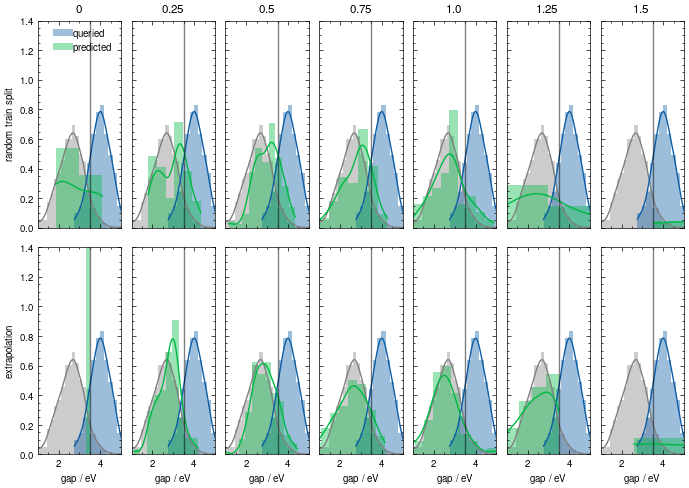

In [173]:

fig, ax = plt.subplots(2,7, figsize=(7,5), sharex='all', sharey='all')
temperatures = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]
# for i in range(7):
#     sns.distplot(train_set_random['GFN2_HOMO_LUMO_GAP'] * 27.2114, ax=ax[0,i], color='gray',)
#     sns.distplot(random_bandgaps *  27.2114, ax=ax[0][i], kde_kws={"cut":0}, label='queried')  
#     sns.distplot(random_xtb_results[i]['predicted'], ax=ax[0][i], kde_kws={"cut":0}, label='predicted')
#     print(f'Random set {i} mean: {np.mean(random_xtb_results[i]["predicted"])} eV | predicted {np.mean(random_xtb_results[i]["true"])}' )
    



for i in range(7):
    sns.distplot(train_set_random['GFN2_HOMO_LUMO_GAP'] * 27.2114, ax=ax[0,i], color='gray',)
    sns.distplot(random_bandgaps* 27.2114, ax=ax[0][i], kde_kws={"cut":0}, label='queried')   
    sns.distplot(random_biased_xtb_results[i]['predicted'], ax=ax[0][i], kde_kws={"cut":0}, label='predicted')
    

for i in range(7):
    sns.distplot(train_set_random['GFN2_HOMO_LUMO_GAP'] * 27.2114, ax=ax[1,i], color='gray',)
    sns.distplot(random_bandgaps* 27.2114, ax=ax[1][i], kde_kws={"cut":0}, label='queried')   
    sns.distplot(extrapolation_xtb_results[i]['predicted'], ax=ax[1][i], kde_kws={"cut":0}, label='predicted')
    print(f'Extrpolation set {i} mean: {np.mean(extrapolation_xtb_results[i]["predicted"])} eV | predicted {np.mean(extrapolation_xtb_results[i]["true"])}' )
    


ax[0][0].set_ylabel('random')
ax[0][0].set_ylabel('random train split')
ax[1][0].set_ylabel('extrapolation')

ax[0][0].set_ylim(0, 1.4)
ax[0][0].set_xlim(1, 5)

fig.show()

ax[0,0].legend(handletextpad=0)


for i in range(7):
    ax[-1][i].set_xlabel('gap / eV')

for i, temp in enumerate(temperatures):
    ax[0][i].set_title(f"{temp}")

for row in range(2):
    for col in range(7):
        ax[row][col].vlines(3.5, 0, 1.4, color='k', alpha=.5)

fig.tight_layout()
fig.savefig('20221201_predicted_gap_distributions_biased_extrapolation_sampling.pdf', bbox_inches='tight')

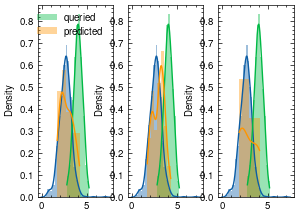

In [175]:
fig, ax = plt.subplots(1, 3)
for i in range(3):
    sns.distplot(train_set_random['GFN2_HOMO_LUMO_GAP'].values * 27.2114, ax=ax[i])
    sns.distplot(random_bandgaps* 27.2114, ax=ax[i], kde_kws={"cut":0}, label='queried')   
    sns.distplot(random_biased_low_temp_xtb_results[i]['predicted'], ax=ax[i], kde_kws={"cut":0}, label='predicted')

ax[0].legend()

## Make again a diversity analysis

In [109]:
def get_sa_scores(smiles):
    sa_scores = []
    for smiles in smiles:
        try:
            mol = Chem.MolFromSmiles(smiles)
            sa_scores.append(calculate_sascore(mol))
        except: 
            pass
    return sa_scores

In [111]:
diversity_metrics = []

for res in random_test_results: 
    sa_scores = get_sa_scores(res['predictions'][res['valid_smiles']])
    metrics = {
        'temperature': res['meta']['temperature'],
        'kl_divergence': res['kl_divergence'],
        'unique_smiles': res['unique_smiles'],
        'fcd': res['frechet_chemnet'][0],
        'valid_smiles': res['fractions_valid_smiles'], 
        'smiles_in_train': res['fractions_smiles_in_train'],
        'sampling': "random",
        'mean_sa_score': np.mean(sa_scores),
    }

    diversity_metrics.append(metrics)

for res in extrapolation_test_results: 
    sa_scores = get_sa_scores(res['predictions'][res['valid_smiles']])
    metrics = {
        'temperature': res['meta']['temperature'],
        'kl_divergence': res['kl_divergence'],
        'unique_smiles': res['unique_smiles'],
        'fcd': res['frechet_chemnet'][0],
        'valid_smiles': res['fractions_valid_smiles'], 
        'smiles_in_train': res['fractions_smiles_in_train'],
        'sampling': "extrapolation",
         'mean_sa_score': np.mean(sa_scores),
    }

    diversity_metrics.append(metrics)



In [112]:
diversity_metrics = pd.DataFrame(diversity_metrics)

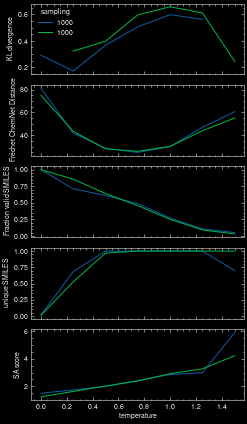

In [119]:
fig, ax = plt.subplots(5,1, sharex='all', figsize=(3.5, 6))

for sampling in ["random", "extrapolation"]:
    subset = diversity_metrics[diversity_metrics['sampling'] == sampling]
    ax[0].plot(subset['temperature'], subset['kl_divergence'], label=train_size)

for sampling in ["random", "extrapolation"]:
    subset = diversity_metrics[diversity_metrics['sampling'] == sampling]
    ax[1].plot(subset['temperature'], subset['fcd'], label=train_size)


for sampling in ["random", "extrapolation"]:
    subset = diversity_metrics[diversity_metrics['sampling'] == sampling]
    ax[2].plot(subset['temperature'], subset['valid_smiles'], label=train_size)


for sampling in ["random", "extrapolation"]:
    subset = diversity_metrics[diversity_metrics['sampling'] == sampling]
    ax[3].plot(subset['temperature'], subset['unique_smiles'], label=train_size)

for sampling in ["random", "extrapolation"]:
    subset = diversity_metrics[diversity_metrics['sampling'] == sampling]
    ax[4].plot(subset['temperature'], subset['mean_sa_score'], label=train_size)

ax[0].set_ylabel('KL divergence')
ax[1].set_ylabel('Fréchet ChemNet Distance')
ax[2].set_ylabel('Fraction valid SMILES')
ax[3].set_ylabel('unique SMILES')
ax[4].set_ylabel('SA score')


ax[0].legend(title='sampling')
ax[-1].set_xlabel('temperature')
fig.tight_layout()